In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from numpy.core.umath_tests import inner1d
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import math
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge


/Users/yasudakoudai/.pyenv/versions/anaconda2-4.3.1/envs/python36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
def rmse(clf,x_test,y_test):
    y_test_predict=clf.predict(x_test)
    rmse=np.sqrt(((y_test_predict-y_test)**2).mean())
    return rmse

In [4]:
#データ読み込み
df_test=pd.read_csv('test.csv')
df_train=pd.read_csv('train.csv')
df_test_id=df_test['Id']
df_train_id=df_train['Id']
df_test=df_test.drop('Id',axis=1)
df_train=df_train.drop('Id',axis=1)

In [5]:
print(df_train.shape,df_test.shape)

(1460, 80) (1459, 79)


/Users/yasudakoudai/.pyenv/versions/anaconda2-4.3.1/envs/python36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


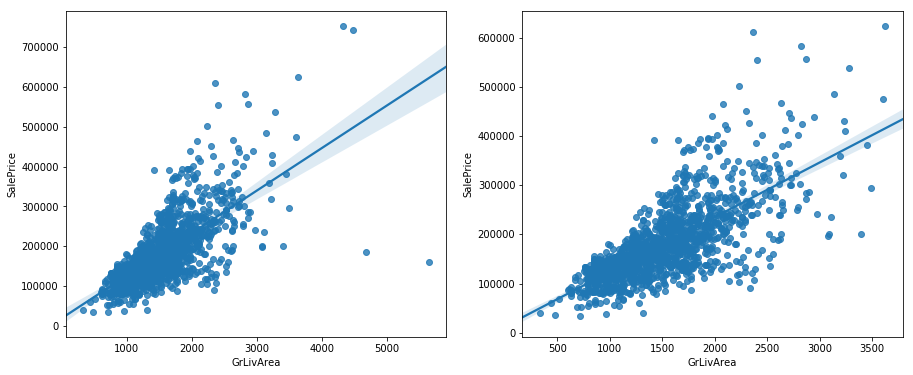

In [6]:
#外れ値の削除
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.regplot(x=df_train['GrLivArea'],y=df_train['SalePrice'])
plt.subplot(1,2,2)
df_train=df_train.drop(df_train[(df_train['GrLivArea']>4000)].index)
sns.regplot(x=df_train['GrLivArea'],y=df_train['SalePrice'])
plt.show()

In [7]:
df_train.isnull().sum()[df_train.isnull().sum()>0].sort_values(ascending=False)

PoolQC          1451
MiscFeature     1402
Alley           1365
Fence           1176
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

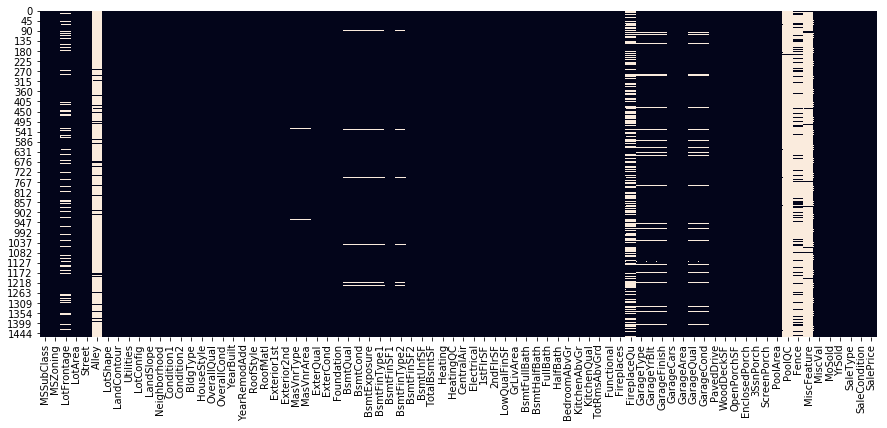

In [8]:
plt.figure(figsize=(15,6))
sns.heatmap(df_train.isnull(),cbar=False)

In [9]:
##trainデータ前処理
df=df_train.copy()
#欠損値処理
a=0.2
b=len(df)*a
index=df.isnull().sum()<b
index_dict=dict(index)
columns_list=list(df.columns)
for i in range(len(columns_list)):
    if index_dict[columns_list[i]]==False:
        df=df.drop(columns_list[i],axis=1)


#前処理のため目的変数priceをとりあえず分離
df_price=df['SalePrice']
df=df.drop('SalePrice',axis=1)

#変数を型ごとに分ける
df_int=df.select_dtypes(include='int')
df_float=df.select_dtypes(include='float')
df_object=df.select_dtypes(include='object')

#int型の欠損値を0で補う
df_int=df_int.fillna(0)

#float型も欠損値を平均値で補う
df_float=df_float.fillna(df_float.mean())


#数値型として結合
df_number=pd.concat([df_int,df_float],axis=1).astype(float)

#カテゴリー変数を抽出
categorial_feature_names=['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition']
#その中でmappingする変数を抽出
mapping_feature_names=['Utilities', 'ExterQual', 'ExterCond', 
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'HeatingQC',  'KitchenQual',
       'Functional', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive']

#ダミー変数化
df_before_dummy=df_object.drop(mapping_feature_names,axis=1)
df_dummy=pd.get_dummies(df_before_dummy)

#mapping辞書作成（nanの辞書を入れているのはtestデータ用）
feature_values=[['AllPub','NoSewr','NoSeWa','ELO'],['Ex','Gd','TA','Fa','Po'],['Ex','Gd','TA','Fa','Po'],
                ['Ex','Gd','TA','Fa','Po','NA'],['Ex','Gd','TA','Fa','Po','NA'],['Gd','Av','Mn','No','NA'],['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA'],
               ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA'],['Ex','Gd','TA','Fa','Po'],['Ex','Gd','TA','Fa','Po'],
               ['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal'],['Fin','RFn','Unf','NA'],
               ['Ex','Gd','TA','Fa','Po','NA'],['Ex','Gd','TA','Fa','Po','NA'],['Y','P','N']]
mapping_list=[]
dic_nan={np.nan:0}
for i in range(len(feature_values)):
    keys=feature_values[i]
    values=reversed(range(1,len(feature_values[i])+1))
    dic=dict(zip(keys,values))
    dic.update(dic_nan)
    mapping_list.append(dic)

    
#mapping実行
df_mapping=df_object.loc[:,mapping_feature_names]
for i in range(len(mapping_feature_names)):
    df_mapping[mapping_feature_names[i]]=df_mapping[mapping_feature_names[i]].map(mapping_list[i])
    
#説明変数用のデータフレーム
df_x=pd.concat([df_number,df_dummy,df_mapping],axis=1)


#priceも合わせたデータフレーム
df_clean=pd.concat([df_x,df_price],axis=1)


In [10]:
##testデータ前処理
df_val=df_test.copy()
#欠損値処理
a=0.2
b=len(df_val)*a
index_val=df_val.isnull().sum()<b
index_dict_val=dict(index_val)
columns_list_val=list(df_val.columns)
for i in range(len(columns_list_val)):
    if index_dict_val[columns_list_val[i]]==False:
        df_val=df_val.drop(columns_list[i],axis=1)
        
#df=df.dropna()
#testデータは行を削除してはいけない

#前処理のため目的変数priceをとりあえず分離
#df_price=df['SalePrice']
#df=df.drop('SalePrice',axis=1)
#df_valには'SalePrice'の列はない

#変数を型ごとに分ける
df_int_val=df_val.select_dtypes(include='int')
df_float_val=df_val.select_dtypes(include='float')
df_object_val=df_val.select_dtypes(include='object')

#int型、float型の欠損値を0で補う
df_int_val=df_int_val.fillna(0)
df_float_val=df_float_val.fillna(df_float_val.mean())

#数値型として結合
df_number_val=pd.concat([df_int_val,df_float_val],axis=1).astype(int)

#カテゴリー変数を抽出
categorial_feature_names_val=['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition']
#その中でmappingする変数を抽出
mapping_feature_names_val=['Utilities', 'ExterQual', 'ExterCond', 
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'HeatingQC',  'KitchenQual',
       'Functional', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive']

#ダミー変数化
df_before_dummy_val=df_object_val.drop(mapping_feature_names_val,axis=1)
df_dummy_val=pd.get_dummies(df_before_dummy_val)

#mapping辞書作成（nanの辞書を入れているのはtestデータ用）
feature_values_val=[['AllPub','NoSewr','NoSeWa','ELO'],['Ex','Gd','TA','Fa','Po'],['Ex','Gd','TA','Fa','Po'],
                ['Ex','Gd','TA','Fa','Po','NA'],['Ex','Gd','TA','Fa','Po','NA'],['Gd','Av','Mn','No','NA'],['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA'],
               ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA'],['Ex','Gd','TA','Fa','Po'],['Ex','Gd','TA','Fa','Po'],
               ['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal'],['Fin','RFn','Unf','NA'],
               ['Ex','Gd','TA','Fa','Po','NA'],['Ex','Gd','TA','Fa','Po','NA'],['Y','P','N']]
mapping_list_val=[]
dic_nan={np.nan:0}
for i in range(len(feature_values_val)):
    keys=feature_values_val[i]
    values=reversed(range(1,len(feature_values_val[i])+1))
    dic=dict(zip(keys,values))
    dic.update(dic_nan)
    mapping_list_val.append(dic)

    
#mapping実行
df_mapping_val=df_object_val.loc[:,mapping_feature_names_val]
for i in range(len(mapping_feature_names_val)):
    df_mapping_val[mapping_feature_names_val[i]]=df_mapping_val[mapping_feature_names_val[i]].map(mapping_list_val[i])
    
#説明変数用のデータフレーム
df_x_val=pd.concat([df_number_val,df_dummy_val,df_mapping_val],axis=1)


In [11]:
print(df_train.shape,df_test.shape)
print(df_x.shape,df_x_val.shape)

(1456, 80) (1459, 79)
(1456, 217) (1459, 204)


In [12]:
#columnsを揃える
missing_columns=set(df_x.columns)-set(df_x_val.columns)
for column in missing_columns:
    df_x_val[column]=0

missing_columns_sub=set(df_x_val.columns)-set(df_x.columns)
for column in missing_columns_sub:
    df_x[column]=0

print(df_train.shape,df_test.shape)
print(df_x.shape,df_x_val.shape)
print(set(df_x.columns)==set(df_x_val.columns))

(1456, 80) (1459, 79)
(1456, 217) (1459, 217)
True


count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64


/Users/yasudakoudai/.pyenv/versions/anaconda2-4.3.1/envs/python36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


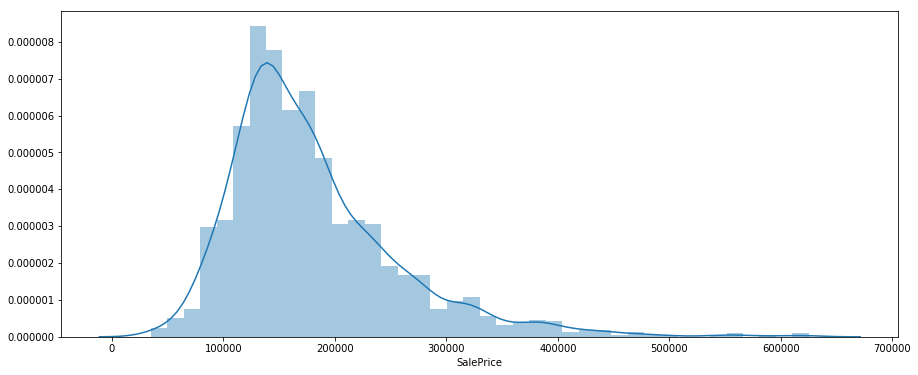

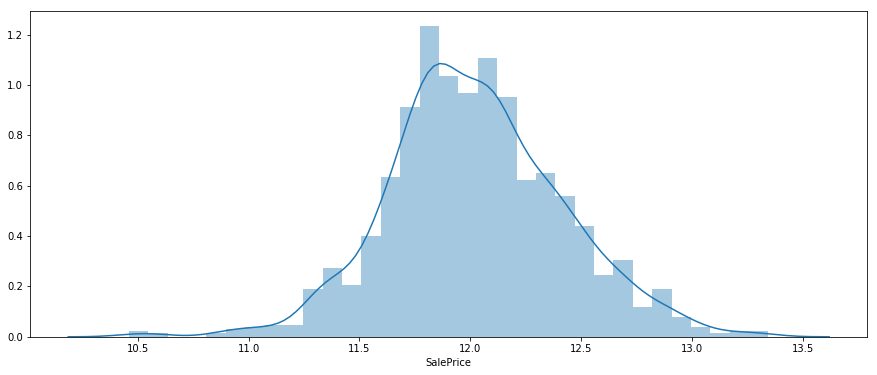

In [13]:
#SalePriceの観察
print(df_price.describe())
df_log_price=df_price.apply(np.log)
plt.figure(figsize=(15,6))
sns.distplot(df_price)
plt.show()
plt.figure(figsize=(15,6))
sns.distplot(df_log_price)

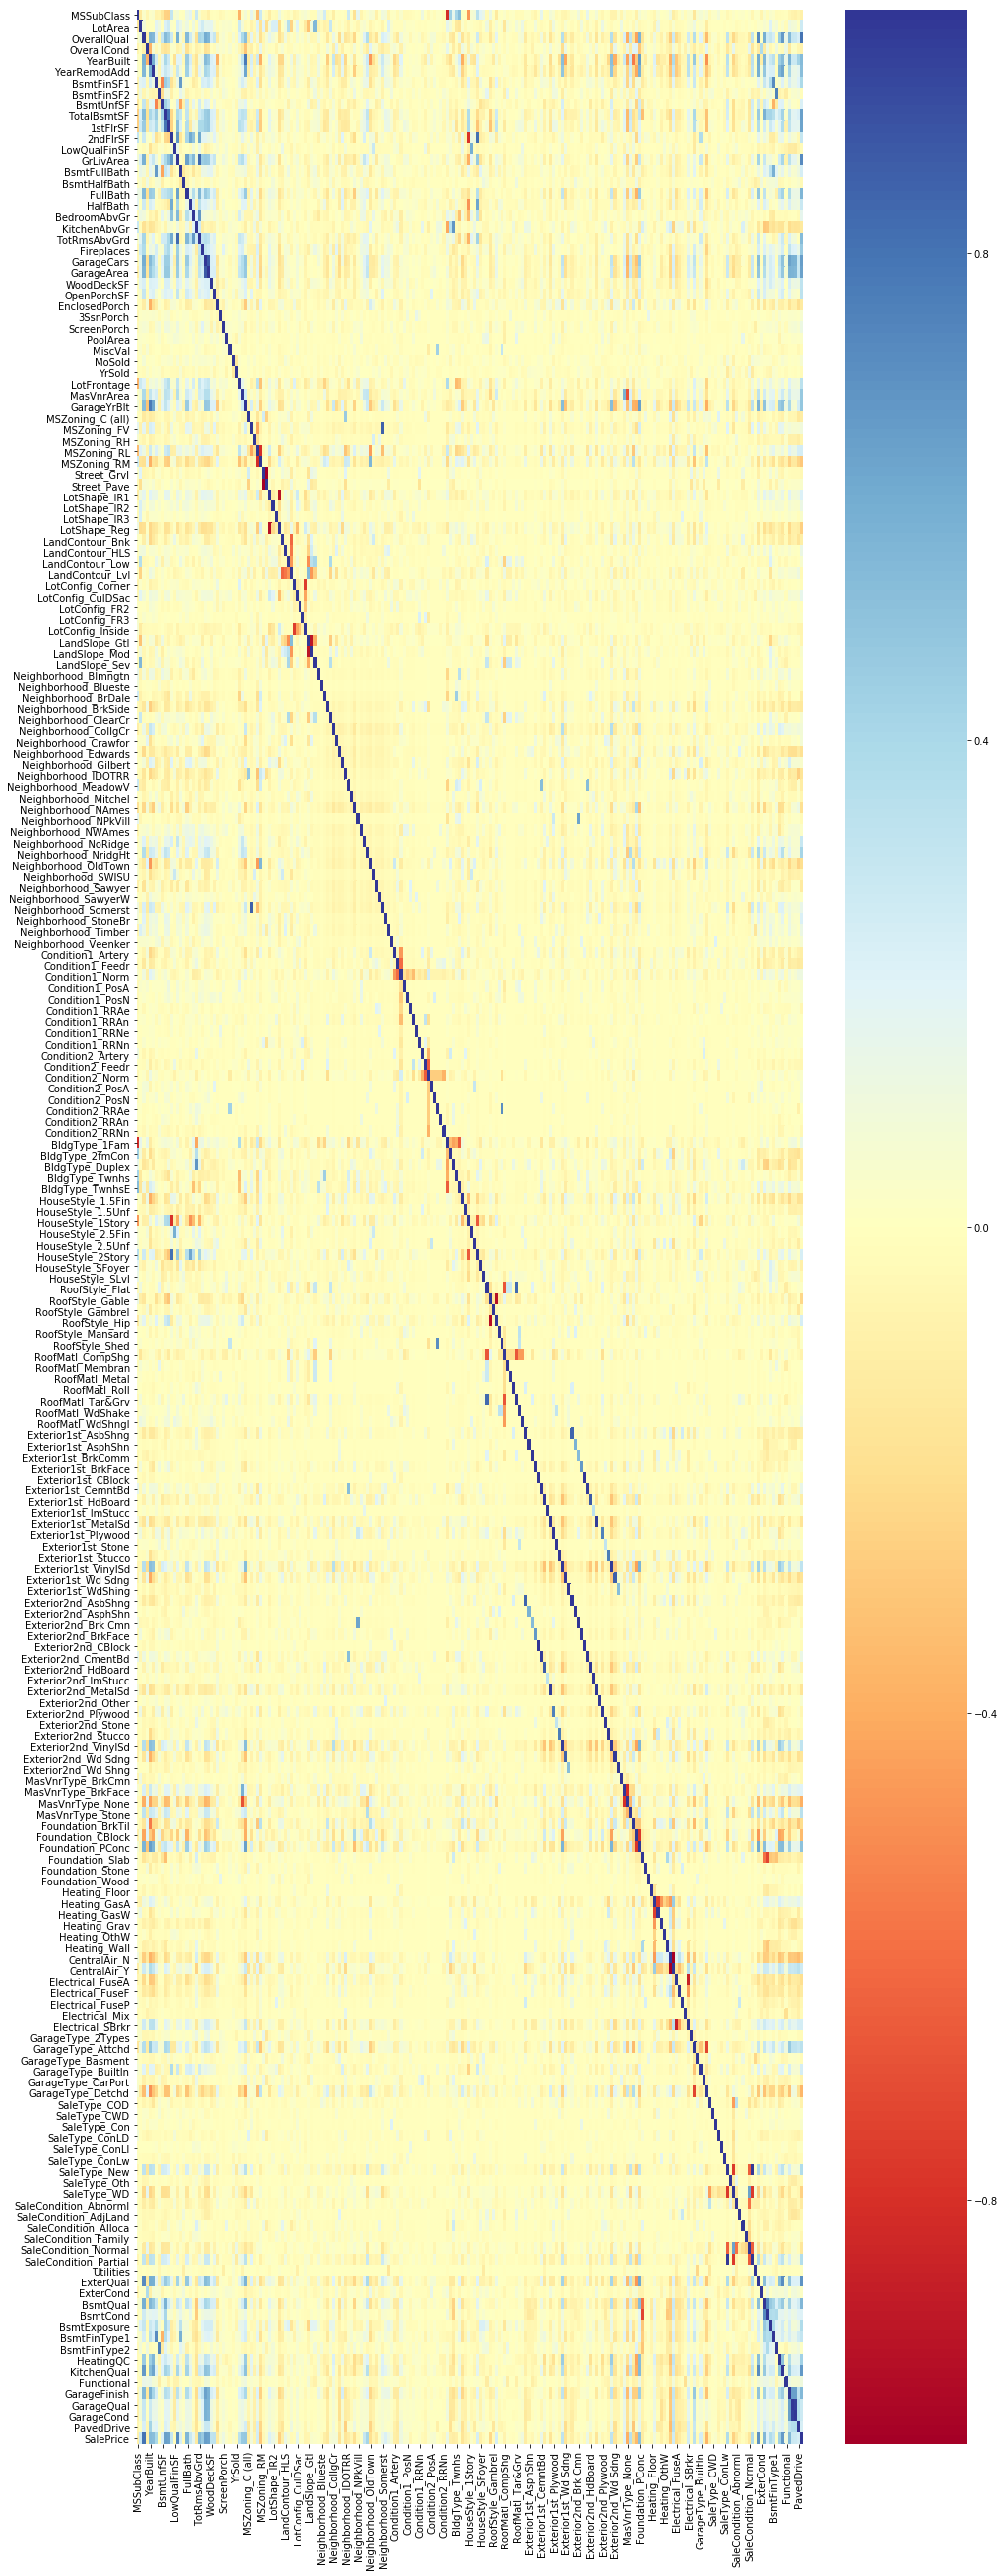

In [14]:
#相関係数チェック
plt.figure(figsize=(15,45))
sns.heatmap(df_clean.corr(),cmap='RdYlBu')

In [15]:
corr_with_price=pd.DataFrame(df_clean.corr().iloc[:,-1])
corr_with_price.columns=['相関係数']
corr_with_price['絶対値']=abs(corr_with_price['相関係数'])
corr_with_price=corr_with_price.drop('SalePrice')
corr_with_price.sort_values('絶対値',ascending=False).head()

#変数を減らす
#相関の絶対値top50
pickup_features=corr_with_price.sort_values('絶対値',ascending=False).head(175).index
df_pickup=df_x[pickup_features]
df_pickup_val=df_x_val[pickup_features]


In [16]:
corr_with_price=pd.DataFrame(df_clean.corr().iloc[:,-1])
corr_with_price.columns=['相関係数']
corr_with_price['絶対値']=abs(corr_with_price['相関係数'])
corr_with_price=corr_with_price.drop('SalePrice')
corr_with_price.sort_values('絶対値',ascending=False).head(20)


,相関係数,絶対値
OverallQual,0.800858,0.800858
GrLivArea,0.720516,0.720516
ExterQual,0.694628,0.694628
KitchenQual,0.666217,0.666217
GarageCars,0.649256,0.649256
TotalBsmtSF,0.646584,0.646584
GarageArea,0.636964,0.636964
1stFlrSF,0.625235,0.625235
FullBath,0.559048,0.559048
BsmtQual,0.551670,0.551670


In [17]:
#shape確認
print(df_pickup.shape,df_x.shape)
print(df_pickup_val.shape,df_x_val.shape)

(1456, 175) (1456, 217)
(1459, 175) (1459, 217)


In [18]:
#データ準備
#説明変数は標準化
#目的変数はlogを取って正規分布に近い形にする
ss=StandardScaler()
x=df_pickup.values
x_std=ss.fit_transform(x)
y=df_price.apply(np.log).values
x_train,x_test,y_train,y_test=train_test_split(x_std,y,random_state=2,test_size=0.3)


#testdataも
ss_val=StandardScaler()
x_val=ss_val.fit_transform(df_pickup_val.values)

/Users/yasudakoudai/.pyenv/versions/anaconda2-4.3.1/envs/python36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/yasudakoudai/.pyenv/versions/anaconda2-4.3.1/envs/python36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
#学習
reg_machines=[RandomForestRegressor(),GradientBoostingRegressor(),Ridge(alpha=1000),Lasso(alpha=1000),ElasticNet(alpha=1000)]

df_predicted_values=pd.DataFrame()
train_score_li=[]
test_score_li=[]
rmse_score_li=[]



for i in range(len(reg_machines)):
    
    reg=reg_machines[i]
    reg.fit(x_train,y_train)
    train_score=reg.score(x_train,y_train)
    test_score=reg.score(x_test,y_test)
    rmse_score=rmse(reg,x_test,y_test)
    
    df_reg_predict=(pd.DataFrame(reg.predict(x_val))).apply(np.exp)
    df_reg_predict.columns=['defnition after']
    df_predicted_values=pd.concat([df_predicted_values,df_reg_predict],axis=1)
    train_score_li.append(train_score)
    test_score_li.append(test_score)
    rmse_score_li.append(rmse_score)
    
df_predicted_values.columns=['RandomForestRegressor','GradientBoostingRegressor','Ridge','Lasso','ElasticNet']
dc_score={'train':train_score_li,'test':test_score_li,'RMSE':rmse_score_li}
df_score=pd.DataFrame(dc_score)
df_score.index=['RandomForestRegressor','GradientBoostingRegressor','Ridge','Lasso','ElasticNet']
df_score

,train,test,RMSE
RandomForestRegressor,0.972396,0.852915,0.150888
GradientBoostingRegressor,0.966070,0.899237,0.124889
Ridge,0.914213,0.909740,0.118201
Lasso,0.000000,-0.017681,0.396897
ElasticNet,0.000000,-0.017681,0.396897


In [20]:
#gradientboostingregrsoor
params_grad={'n_estimators':[50,60],'max_depth':[3,4,5],'learning_rate':[0.1,0.05,0.2]}
kf=KFold(n_splits=10,random_state=0,shuffle=True)
gs_grad=GridSearchCV(GradientBoostingRegressor(),params_grad,cv=kf)
gs_grad.fit(x_train,y_train)
print(gs_grad.score(x_train,y_train))
print(gs_grad.score(x_test,y_test))
print(gs_grad.best_params_)
print(rmse(gs_grad,x_test,y_test))

0.9697823386182204
0.9034989708731813
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 60}
0.12221880076397686


In [ ]:
gs_grad2=GradientBoostingRegressor(n_estimators=60,learning_rate=0.2,max_depth=3)

In [34]:
#randomforestregressor
params_rtree={'n_estimators':[100,50],'max_depth':[16]}
gs_rtree=GridSearchCV(RandomForestRegressor(),params_rtree,cv=kf)
gs_rtree.fit(x_train,y_train)
print(gs_rtree.score(x_test,y_test))
print(gs_rtree.best_params_)
print(rmse(gs_rtree,x_test,y_test))

0.8747059174342634
{'max_depth': 16, 'n_estimators': 100}
0.13926350643200888


In [22]:
#ridge回帰
params_ridge={'alpha':[100,150,200]}

gs_ridge=GridSearchCV(Ridge(),params_ridge,cv=kf)
gs_ridge.fit(x_train,y_train)
print(gs_ridge.score(x_train,y_train))
print(gs_ridge.score(x_test,y_test))
print(gs_ridge.best_params_)
print(rmse(gs_ridge,x_test,y_test))

0.9381824820312565
0.9249581813596081
{'alpha': 150}
0.10777641189162118


In [23]:
#ElasticNet
params_net={'alpha':[0.055,0.01,0.05,0.08],'l1_ratio':[0.1,0.06,0.05]}
gs_net=GridSearchCV(ElasticNet(),params_net,cv=kf)
gs_net.fit(x_train,y_train)
print(gs_net.score(x_train,y_train))
print(gs_net.score(x_test,y_test))
print(gs_net.best_params_)
print(rmse(gs_net,x_test,y_test))


0.9353791278282626
0.9273181800859842
{'alpha': 0.05, 'l1_ratio': 0.06}
0.10606813732517212


In [24]:
#Lasso回帰
params_lasso={'alpha':[0.01,0.005,0.001,0.1]}
gs_lasso=GridSearchCV(Lasso(),params_lasso,cv=kf)
gs_lasso.fit(x_train,y_train)
print(gs_lasso.score(x_train,y_train))
print(gs_lasso.score(x_test,y_test))
print(gs_lasso.best_params_)
print(rmse(gs_lasso,x_test,y_test))


0.9320411350154312
0.9272945479607099
{'alpha': 0.005}
0.10608537968228171


In [25]:
#stackingのためのデータフレーム作成

predict_grad=gs_grad.predict(x_test)
predict_rtree=gs_rtree.predict(x_test)
predict_ridge=gs_ridge.predict(x_test)
predict_net=gs_net.predict(x_test)
predict_lasso=gs_lasso.predict(x_test)

df_final=pd.concat([pd.DataFrame(predict_grad),pd.DataFrame(predict_rtree),pd.DataFrame(predict_ridge),
                    pd.DataFrame(predict_net),pd.DataFrame(predict_lasso),
                    pd.DataFrame(y_test)],
                   axis=1)
df_final.columns=['GradientBoostingRegressor','RandomForestRegressor','Ridge','ElasticNet','Lasso','y_test']
df_final.head(10)

,GradientBoostingRegressor,RandomForestRegressor,Ridge,ElasticNet,Lasso,y_test
0,12.375265,12.217145,12.546344,12.518514,12.492810,12.458775
1,12.118257,12.046485,12.133571,12.135951,12.136125,12.128111
2,11.826224,12.070151,11.793336,11.824125,11.852318,11.775290
3,11.828994,11.947308,11.711936,11.713841,11.748988,11.626254
4,11.802253,11.830359,11.795601,11.817826,11.833758,11.904968
5,11.705951,11.677857,11.663992,11.680315,11.703253,11.771436
6,12.161083,12.165445,12.133017,12.137219,12.142155,12.180755
7,11.835928,11.778668,11.773762,11.761715,11.761451,11.824080
8,12.849317,12.762329,12.745104,12.738467,12.727018,12.721886
9,11.309846,11.300654,11.311814,11.281027,11.256754,10.976782


In [26]:
#stackingのモデル生成
#Lasso回帰を用いるのでlassoの結果は外す
x_final=df_final.drop('y_test',axis=1).drop('Lasso',axis=1).values
y_final=df_final['y_test'].values

ss_final=StandardScaler()
x_std_final=ss_final.fit_transform(x_final)

reg_params={'alpha':[0.1,0.01,0.005,0.002]}
reg=GridSearchCV(Lasso(),reg_params,cv=kf)
reg.fit(x_std_final,y_final)
print(reg.best_params_)
print(reg.score(x_std_final,y_final))
print(rmse(reg,x_std_final,y_final))

{'alpha': 0.005}
0.9298328822173185
0.10421707127582583


In [27]:
#stackingモデルからpredict生成
predict_grad_val=gs_grad.predict(x_val)
predict_rtree_val=gs_rtree.predict(x_val)
predict_ridge_val=gs_ridge.predict(x_val)
predict_net_val=gs_net.predict(x_val)
predict_lasso_val=gs_lasso.predict(x_val)



df_final_val=pd.concat([pd.DataFrame(predict_grad_val),pd.DataFrame(predict_rtree_val),pd.DataFrame(predict_ridge_val),
                       pd.DataFrame(predict_net_val),pd.DataFrame(predict_lasso_val)]
                       ,axis=1)
df_final_val.columns=['GradientBoostingRegressor','RandomForestRegressor','Ridge','ElasticNet','Lasso']

ss_final_val=StandardScaler()
x_std_final_val=ss_final_val.fit_transform(df_final_val.drop('Lasso',axis=1).values)
pred=reg.predict(x_std_final_val)


#提出
df_pred=(pd.DataFrame(pred)).apply(np.exp)
df_pred.columns=['SalePrice']
df_submit_stack=pd.concat([df_test_id,df_pred],axis=1)

df_submit_stack.to_csv('submit_stacking.csv',index=False)
df_submit_stack.tail()

,Id,SalePrice
1454,2915,90596.223088
1455,2916,89803.469853
1456,2917,176897.169344
1457,2918,121981.022422
1458,2919,232628.574738


In [28]:
#最も精度の良いモデルを採用
#提出
df_best=(pd.DataFrame(gs_net.predict(x_val))).apply(np.exp) 
df_best.columns=['SalePrice'] 
df_best_submit=pd.concat([df_test_id,df_best],axis=1) 
df_best_submit.to_csv('bestmodel.csv',index=False) 
df_best.tail()

,SalePrice
1454,87783.952610
1455,87163.512334
1456,176636.208885
1457,117672.686220
1458,227927.186972


In [29]:
#平均を取って提出
df_mean=pd.concat([df_final_val.apply(np.exp),df_pred],axis=1)
df_mean.head()
df_mean['mean']=(df_mean['GradientBoostingRegressor']+df_mean['RandomForestRegressor']+df_mean['Ridge']
                 +df_mean['ElasticNet']+df_mean['Lasso'])/5
df_mean.head()

,GradientBoostingRegressor,RandomForestRegressor,Ridge,ElasticNet,Lasso,SalePrice,mean
0,125228.710119,127286.350706,124911.124030,123798.302994,123154.166626,130778.624247,124875.730895
1,150512.846639,151021.578291,157753.912822,156819.452952,156189.989385,162499.099720,154459.556018
2,183987.884384,172570.050933,185051.032117,182256.517635,181573.746343,189668.833420,181087.846282
3,185920.287342,178420.464421,201264.919728,200044.840530,198263.270984,203910.887743,192782.756601
4,198653.976938,187855.362178,194959.917581,196844.011791,195042.092759,203038.722669,194671.072249


In [30]:
df_mean_submit=pd.concat([df_test_id,df_mean['mean']],axis=1)
df_mean_submit.columns=['Id','SalePrice']
df_mean_submit.to_csv('meansubmit.csv',index=False)
df_mean_submit.head()

,Id,SalePrice
0,1461,124875.730895
1,1462,154459.556018
2,1463,181087.846282
3,1464,192782.756601
4,1465,194671.072249


＊明日やること＊

・特徴量選択
　　相関係数の高い変数50個をpickupしたが、ここは論理的ではなく直感でおこなった。ここをどうするか。rgboostやっても良いが時間がないかも。
  今日までは客観的にやってきたが、少し主観を取り入れてみる。
  家の価値を決める要因は何か？
  50個の中には場所があまりふくまれていない。
・欠損処理
　　単純に0、meanで補ったが、他の補い方も考えてみる。
  例えば、地域ごとに分類するとか。
・新しい特徴量を作る
　　quality,area=size,year(-->old),exp(overallquality)とか


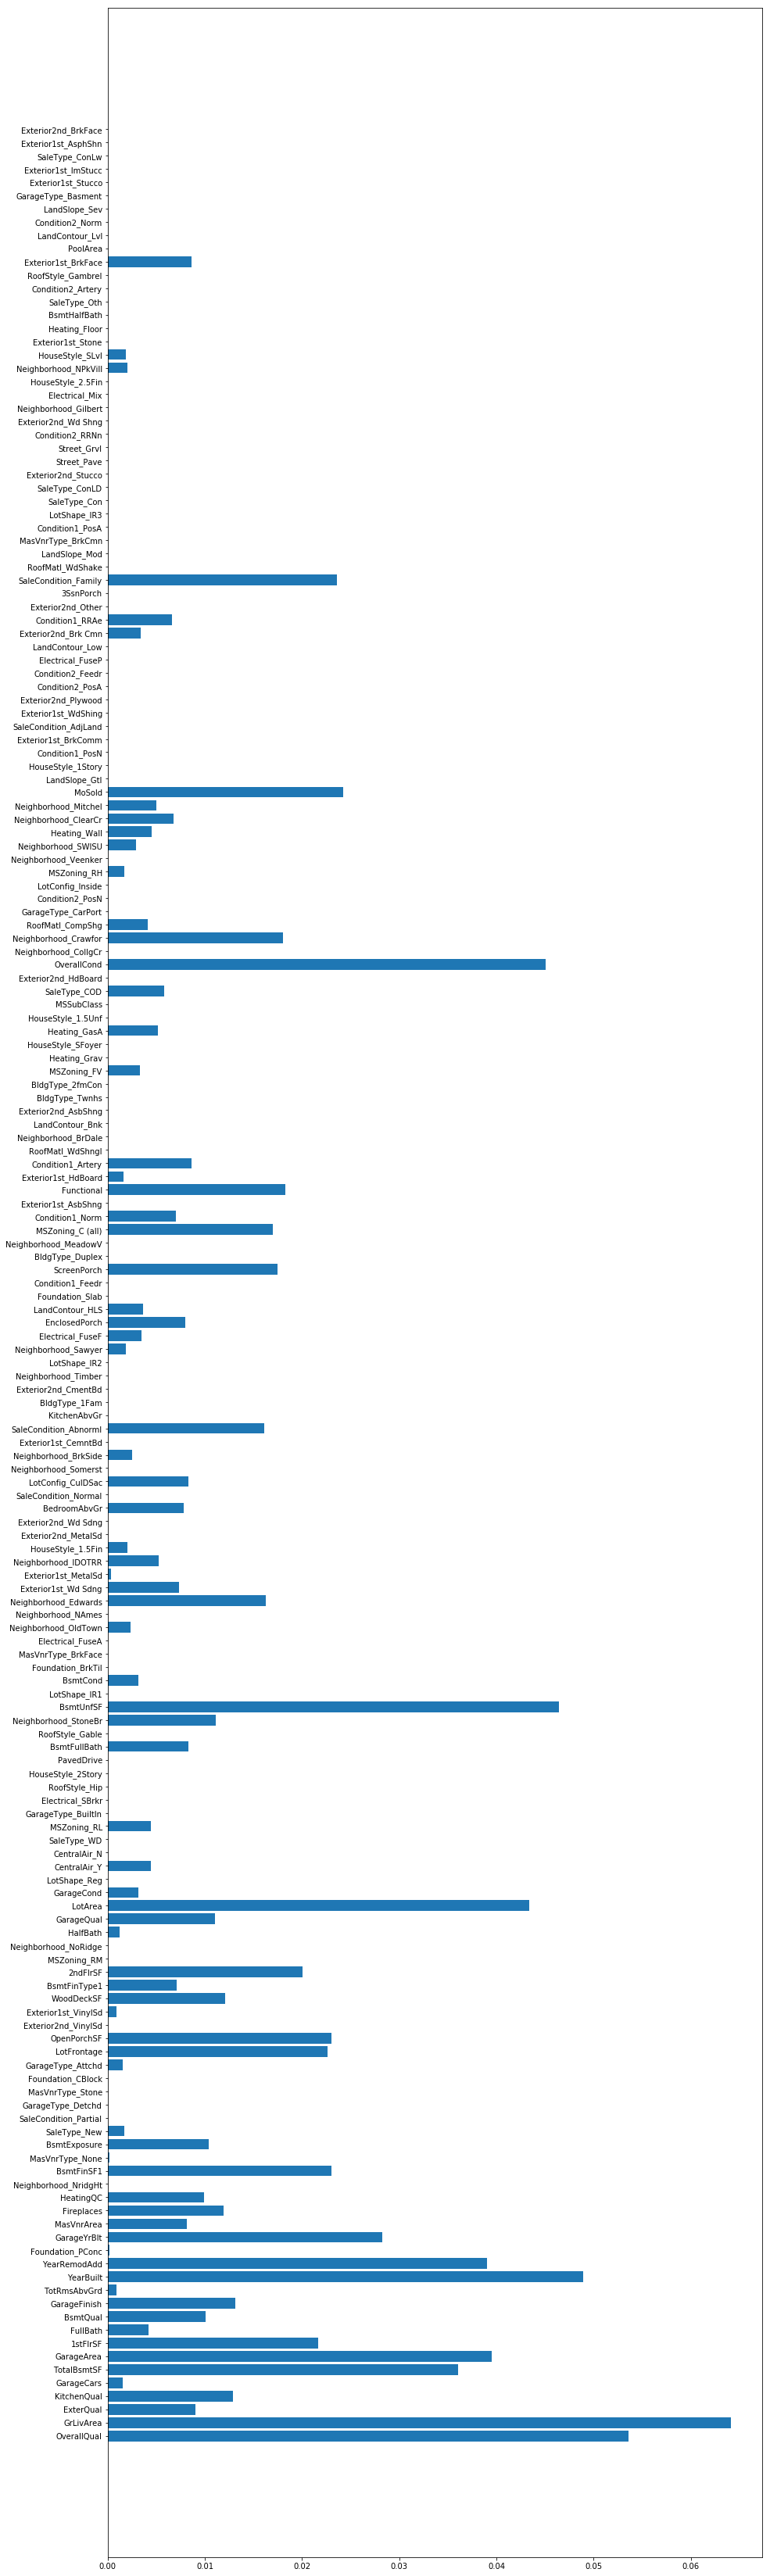

In [40]:
#重要な特徴量
gs_grad2=GradientBoostingRegressor(n_estimators=60,learning_rate=0.2,max_depth=3)
gs_grad2.fit(x_train,y_train)
important=gs_grad2.feature_importances_
n_features=len(important)
plt.figure(figsize=(15,60))
plt.barh(range(n_features),important,align='center')
plt.yticks(np.arange(n_features),df_pickup.columns)
plt.show()

In [43]:
important

array([5.35784651e-02, 6.41283272e-02, 9.01641530e-03, 1.28864487e-02,
       1.53891677e-03, 3.60889288e-02, 3.95248679e-02, 2.16515438e-02,
       4.21894814e-03, 1.00918023e-02, 1.31162081e-02, 9.22963355e-04,
       4.89198612e-02, 3.90707871e-02, 1.79541183e-04, 2.82870540e-02,
       8.11597047e-03, 1.18938181e-02, 9.94080238e-03, 0.00000000e+00,
       2.30167387e-02, 1.68181538e-04, 1.03871814e-02, 1.66643063e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.51283742e-03, 2.26007930e-02, 2.30400501e-02, 0.00000000e+00,
       8.99298193e-04, 1.20740320e-02, 7.10601925e-03, 2.00092611e-02,
       0.00000000e+00, 0.00000000e+00, 1.19702537e-03, 1.10163302e-02,
       4.33978022e-02, 3.11136000e-03, 0.00000000e+00, 4.43184083e-03,
       0.00000000e+00, 0.00000000e+00, 4.42623943e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.26593605e-03, 0.00000000e+00, 1.11053581e-02, 4.64390283e-02,
      

In [ ]:
df_importance=pd.DataFrame()


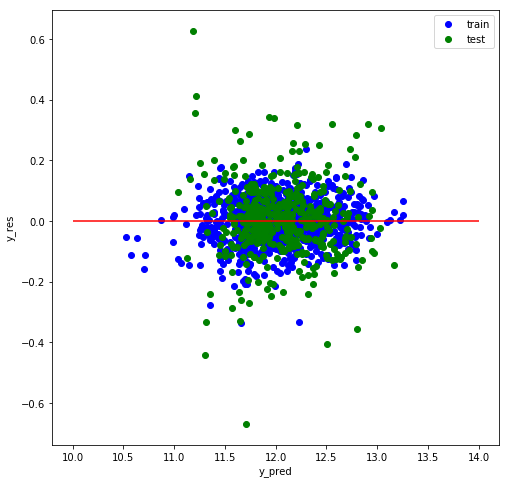

In [48]:
def res_plot(y_train,y_train_pred,y_test,y_test_pred):
    y_train_res=y_train-y_train_pred
    y_test_res=y_test-y_test_pred
    
    plt.figure(figsize=(8,8))
    plt.scatter(y_train_pred,y_train_res,color='blue',marker='o',label='train')
    plt.scatter(y_test_pred,y_test_res,color='green',marker='o',label='test')
    plt.xlabel('y_pred')
    plt.ylabel('y_res')
    plt.legend()
    plt.hlines(y=0,color='red',xmin=10,xmax=14)
    
    
res_plot(y_train,gs_grad.predict(x_train),y_test,gs_grad.predict(x_test))

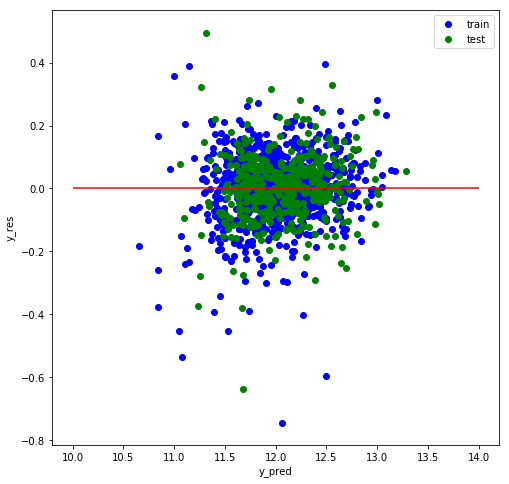

In [49]:
res_plot(y_train,gs_lasso.predict(x_train),y_test,gs_lasso.predict(x_test))

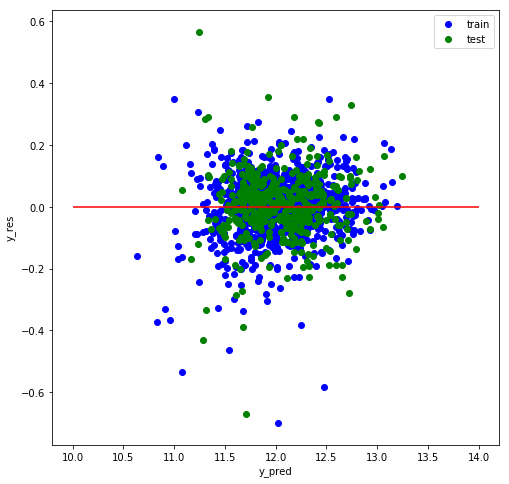

In [50]:
res_plot(y_train,gs_ridge.predict(x_train),y_test,gs_ridge.predict(x_test))

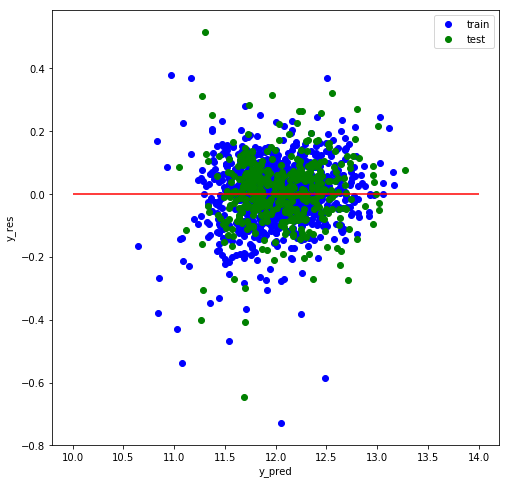

In [51]:
res_plot(y_train,gs_net.predict(x_train),y_test,gs_net.predict(x_test))